In [240]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import math

In [241]:
df = pd.read_excel("data/Nile.xlsx", index_col=0)
df.tail()
# df.Nile.copy().to_list()

,Nile
1966,746
1967,919
1968,718
1969,714
1970,740


                a             P           v             F         K  \
1872  1118.311462  16545.336391   41.688538  31644.336391  0.522853   
1873  1140.108439   9363.657531 -177.108439  24462.657531  0.382774   
1874  1072.316018   7248.597378  137.683982  22347.597378  0.324357   
1875  1116.974768   6366.564813   43.025232  21465.564813  0.296594   
1876  1129.735808   5947.377788   30.264192  21046.377788  0.282584   
...           ...           ...         ...           ...       ...   
1966   963.752506   5501.257942 -217.752506  20600.257942  0.267048   
1967   905.602132   5501.257942   13.397868  20600.257942  0.267048   
1968   909.180006   5501.257942 -191.180006  20600.257942  0.267048   
1969   858.125766   5501.257942 -144.125766  20600.257942  0.267048   
1970   819.637266   5501.257942  -79.637266  20600.257942  0.267048   

              ci     y  
1872  279.285024  1160  
1873  245.556520   963  
1874  234.701071  1210  
1875  230.022761  1160  
1876  227.765706  1160

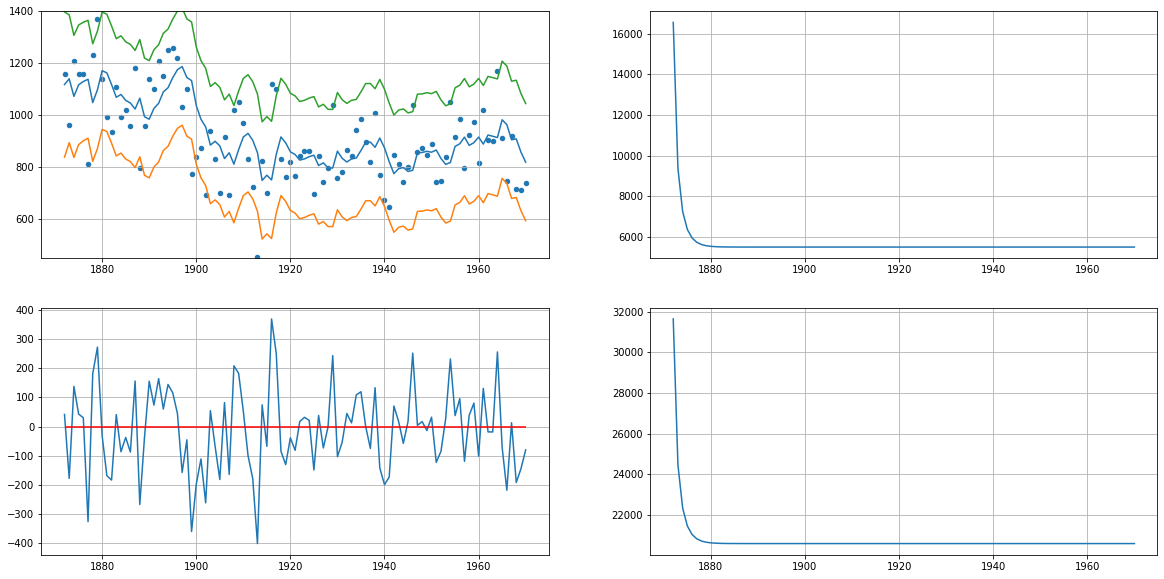

In [242]:
def Kalman_filter(series:pd.Series, P1:float, a1:float, s2_e:float, s2_n:float):
    t_crit = 1.57
    y_list = series.copy().to_list()
    r = pd.DataFrame(columns=['a', 'P', 'v', 'F', 'K', 'ci'])
    
    a = a1
    P = P1
    
    for i,y in enumerate(y_list):
        
        # compute all variables
        v = y - a
        F = P + s2_e
        K = P/F

        # store result for t=i
        r.loc[i] = [a, P, v, F, K, t_crit * F**.5]
        
        if np.isnan(y):
            # filter (nowcasting)
            a_f = a
            P_f = P
            # predict step
            a_p = a
            P_p = P + s2_n

        else:
            #filtering
            a_f = a + K * v
            P_f = P * (1 - K)
            #predict step + 1
            a_p = a_f
            P_p = P_f + s2_n

        # store prediction t+1 for next iteration
        a = a_p
        P = P_p

    r["y"] = series.values
    r.index = series.index
    return r

df_kf = Kalman_filter(series = df.Nile, P1=1e7, a1=0, s2_e = 15099, s2_n = 1469.1)
df_kf = df_kf.iloc[1:]

print(df_kf)

fig, axs = plt.subplots(2,2, figsize=(20,10))

# upper left
ax = axs[0,0]
ax.scatter(df_kf.index, df_kf.y, s=20)
df_kf.a.plot(ax=ax)
(df_kf.a-df_kf.ci).plot(ax=ax)
(df_kf.a+df_kf.ci).plot(ax=ax)
ax.set_ylim(450, 1400)

# lower left
ax = axs[1,0]
ax.plot(df_kf.index, df_kf.v)
ax.hlines(y = 0, xmin= df_kf.index.min(), xmax=df_kf.index.max(), color = 'r', linestyle = '-')

# upper right
ax = axs[0,1]
ax.plot(df_kf.index, df_kf.P)


# lower right
ax = axs[1,1]
ax.plot(df_kf.index, df_kf.F)

# make nice plot
for row in axs:
    for ax in row:
        ax.grid()
        pass


             r            a             N            V        err     y  \
1871  0.000111  1111.220258  9.995969e-08  4030.532767  63.486477  1120   
1872 -0.000470  1110.529257  4.859678e-05  3242.056999  56.939064  1160   
1873 -0.003747  1105.024860  7.465018e-05  2818.473138  53.089294   963   
1874  0.005659  1113.339175  8.864655e-05  2590.916003  50.901041  1210   
1875 -0.000742  1112.248601  9.616566e-05  2468.668074  49.685693  1160   
...        ...          ...           ...          ...        ...   ...   
1966 -0.018950   859.504467  1.002006e-04  2468.803438  49.687055   746   
1967 -0.011433   842.708974  9.615733e-05  2591.167976  50.903516   919   
1968 -0.016485   818.490529  8.863105e-05  2818.942170  53.093711   718   
1969 -0.009830   804.049596  7.462133e-05  3242.930073  56.946730   714   
1970 -0.003866   798.370293  4.854308e-05  4032.157942  63.499275   740   

                 P            v             F         K           ci  
1871  1.000000e+07  1120.000

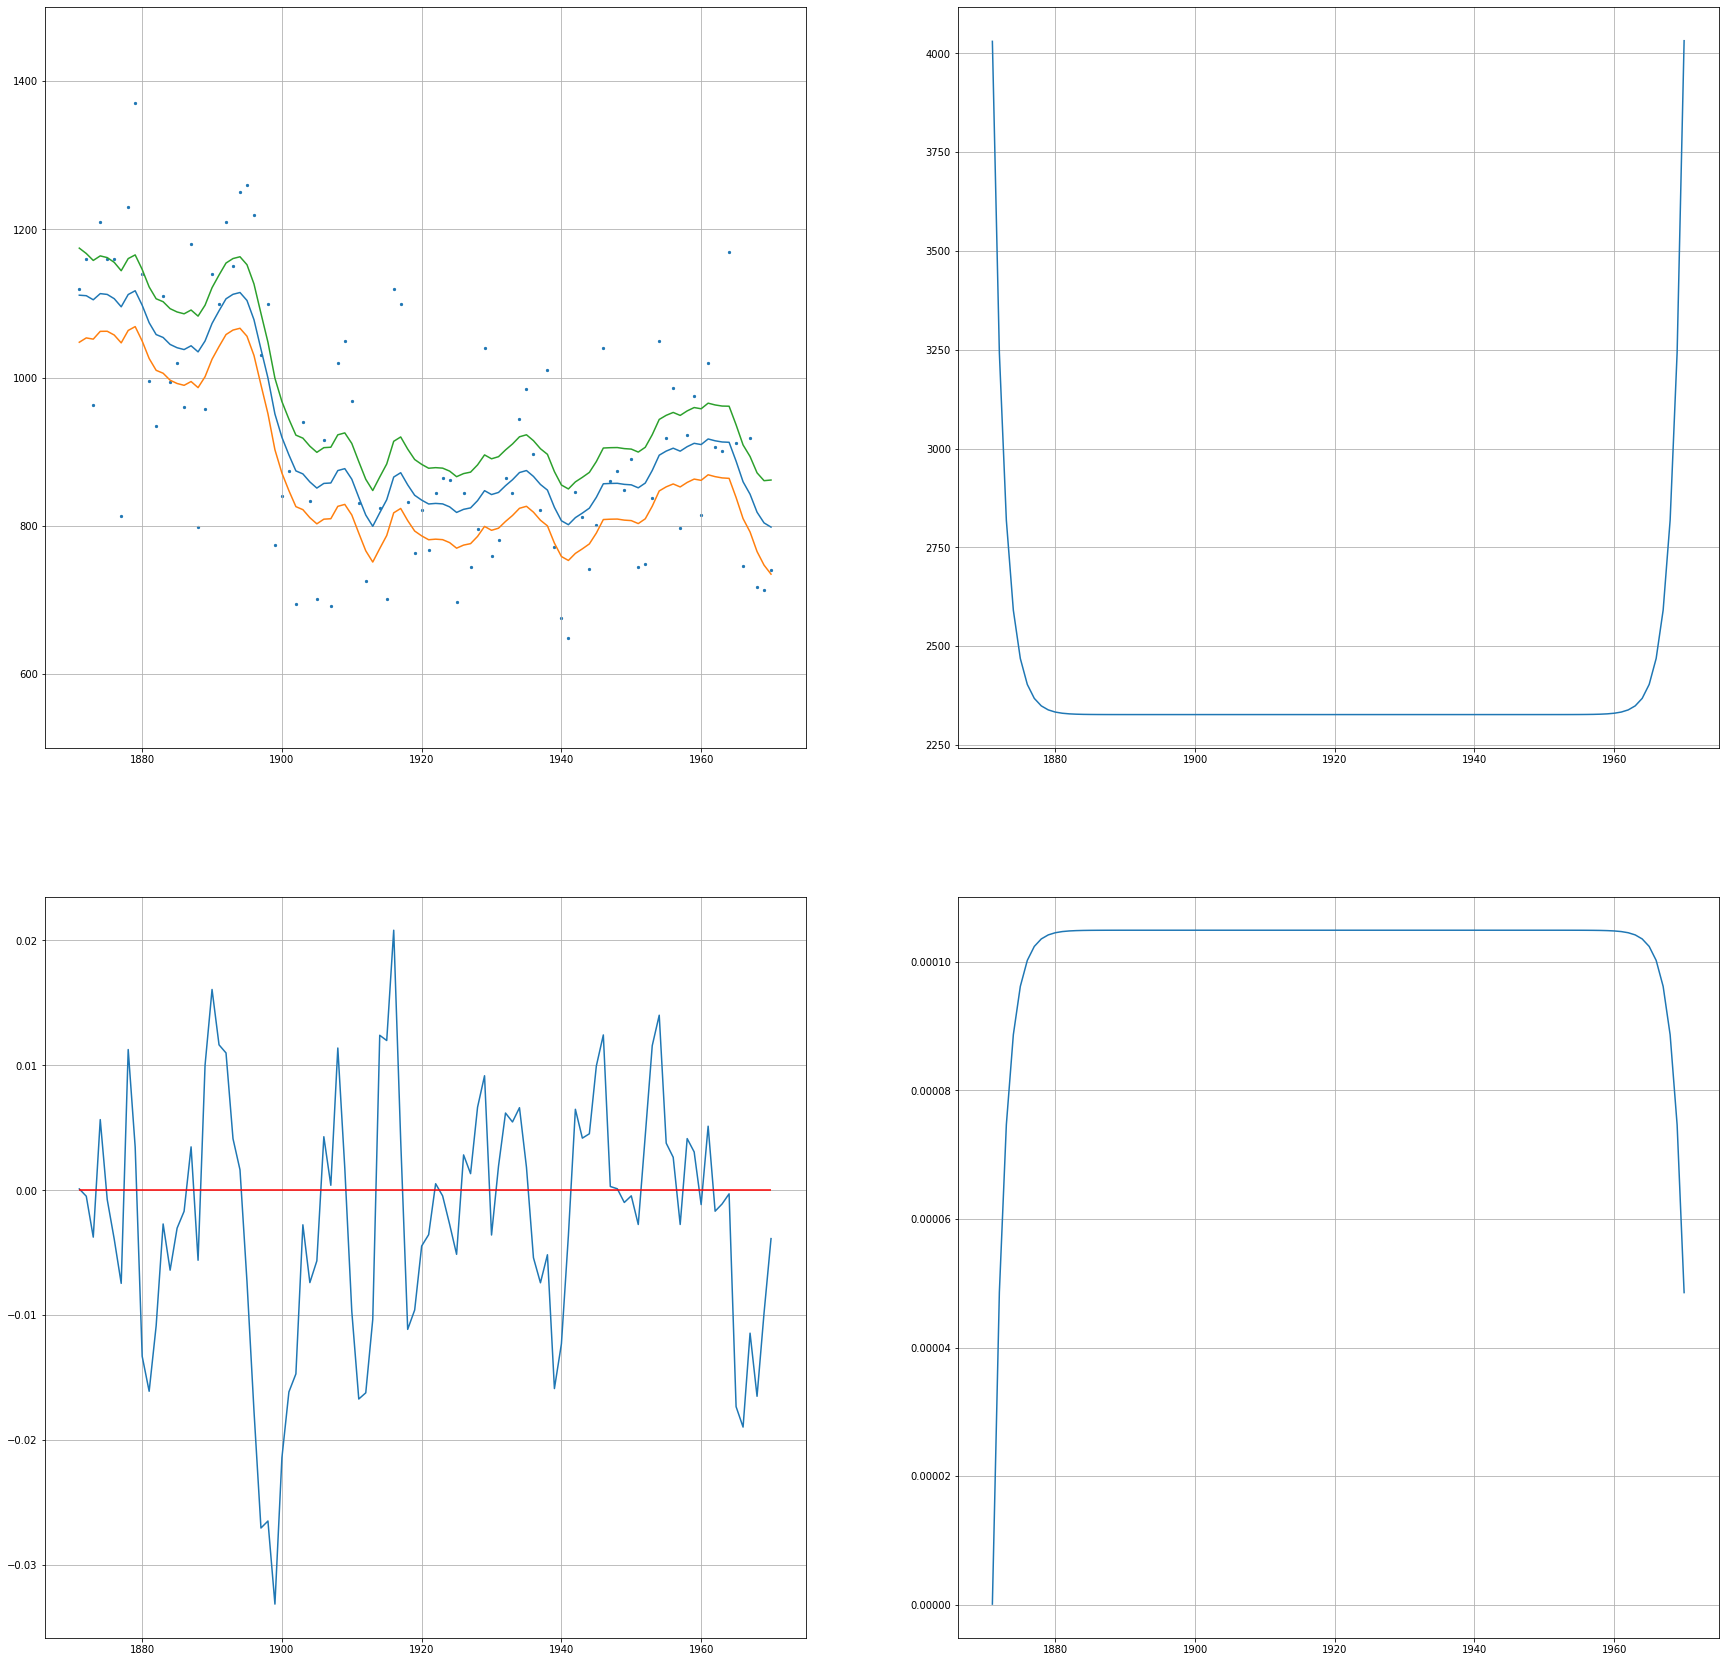

In [243]:
def Kalman_smoother(y: pd.Series, P1: float, a1: float, s2_e: float, s2_n: float, r_n: float, N_n: float):
    df_kf = Kalman_filter(y, P1, a1, s2_e, s2_n)
    ind = df_kf.index
    df_kf = df_kf.iloc[::-1].reset_index(drop=True)
    df_ks = pd.DataFrame(columns=['r', 'a', 'N', 'V', 'err'])

    r = r_n
    N = N_n
    
    for i, row in df_kf.iterrows():
        
        if np.isnan(row['y']):
            r = r
            N = N
        else:
            r = row['F']**-1 * row['v'] + (1-row['K'])*r
            N = row['F']**-1 + (1-row['K'])**2 * N

        a = row['a'] + row['P']*r
        V = row['P'] - row['P']**2 * N

        df_ks.loc[i] = [r, a, N, V, V**0.5]
        
    # store existing data
    df_ks["y"] = df_kf["y"]
    add_columns = [c for c in df_kf.columns if c not in df_ks.columns]
    df_ks[add_columns] = df_kf[add_columns]

    df_ks = df_ks.iloc[::-1].reset_index(drop=True)
    df_ks.index = ind
    return df_ks

df_ks = Kalman_smoother(y=df.Nile, P1=10**7, a1=0, s2_e = 15099, s2_n = 1469.1, r_n = 0, N_n = 0)
print(df_ks)
fig, axs = plt.subplots(2,2, figsize=(30,30))

# upper left
ax = axs[0,0]
ax.scatter(df.index, df.Nile, s=5)
ax.plot(df_ks.index, df_ks.a)
ax.plot(df_ks.index, df_ks.a-df_ks.err)
ax.plot(df_ks.index, df_ks.a+df_ks.err)
ax.set_ylim(500, 1500)

# lower left
ax = axs[1,0]
ax.plot(df_ks.index, df_ks.r)
ax.hlines(y = 0, xmin= df.index.min(), xmax=df.index.max(), color = 'r', linestyle = '-')

# upper right
ax = axs[0,1]
ax.plot(df_ks.index, df_ks.V)


# lower right
ax = axs[1,1]
ax.plot(df_ks.index, df_ks.N)

# make nice plot
for row in axs:
    for ax in row:
        ax.grid()
        pass


             eps          n       var_eps        var_n     y
1871    8.779742   0.163249  15053.516261  1468.884262  1120
1872   49.470743  -0.691001   4865.809832  1364.215762  1160
1873 -142.024860  -5.504397   3285.988117  1307.985896   963
1874   96.660825   8.314315   2771.263073  1277.778165  1210
1875   47.751399  -1.090574   2549.678246  1261.550009  1160
...          ...        ...           ...          ...   ...
1966 -113.504467 -27.839232   2403.066931  1252.841596   746
1967   76.291026 -16.795493   2468.803438  1261.567979   919
1968 -100.490529 -24.218445   2591.167976  1277.811614   718
1969  -90.049596 -14.440934   2818.942170  1308.048159   714
1970  -58.370293  -5.679303   3242.930073  1364.331661   740

[100 rows x 5 columns]


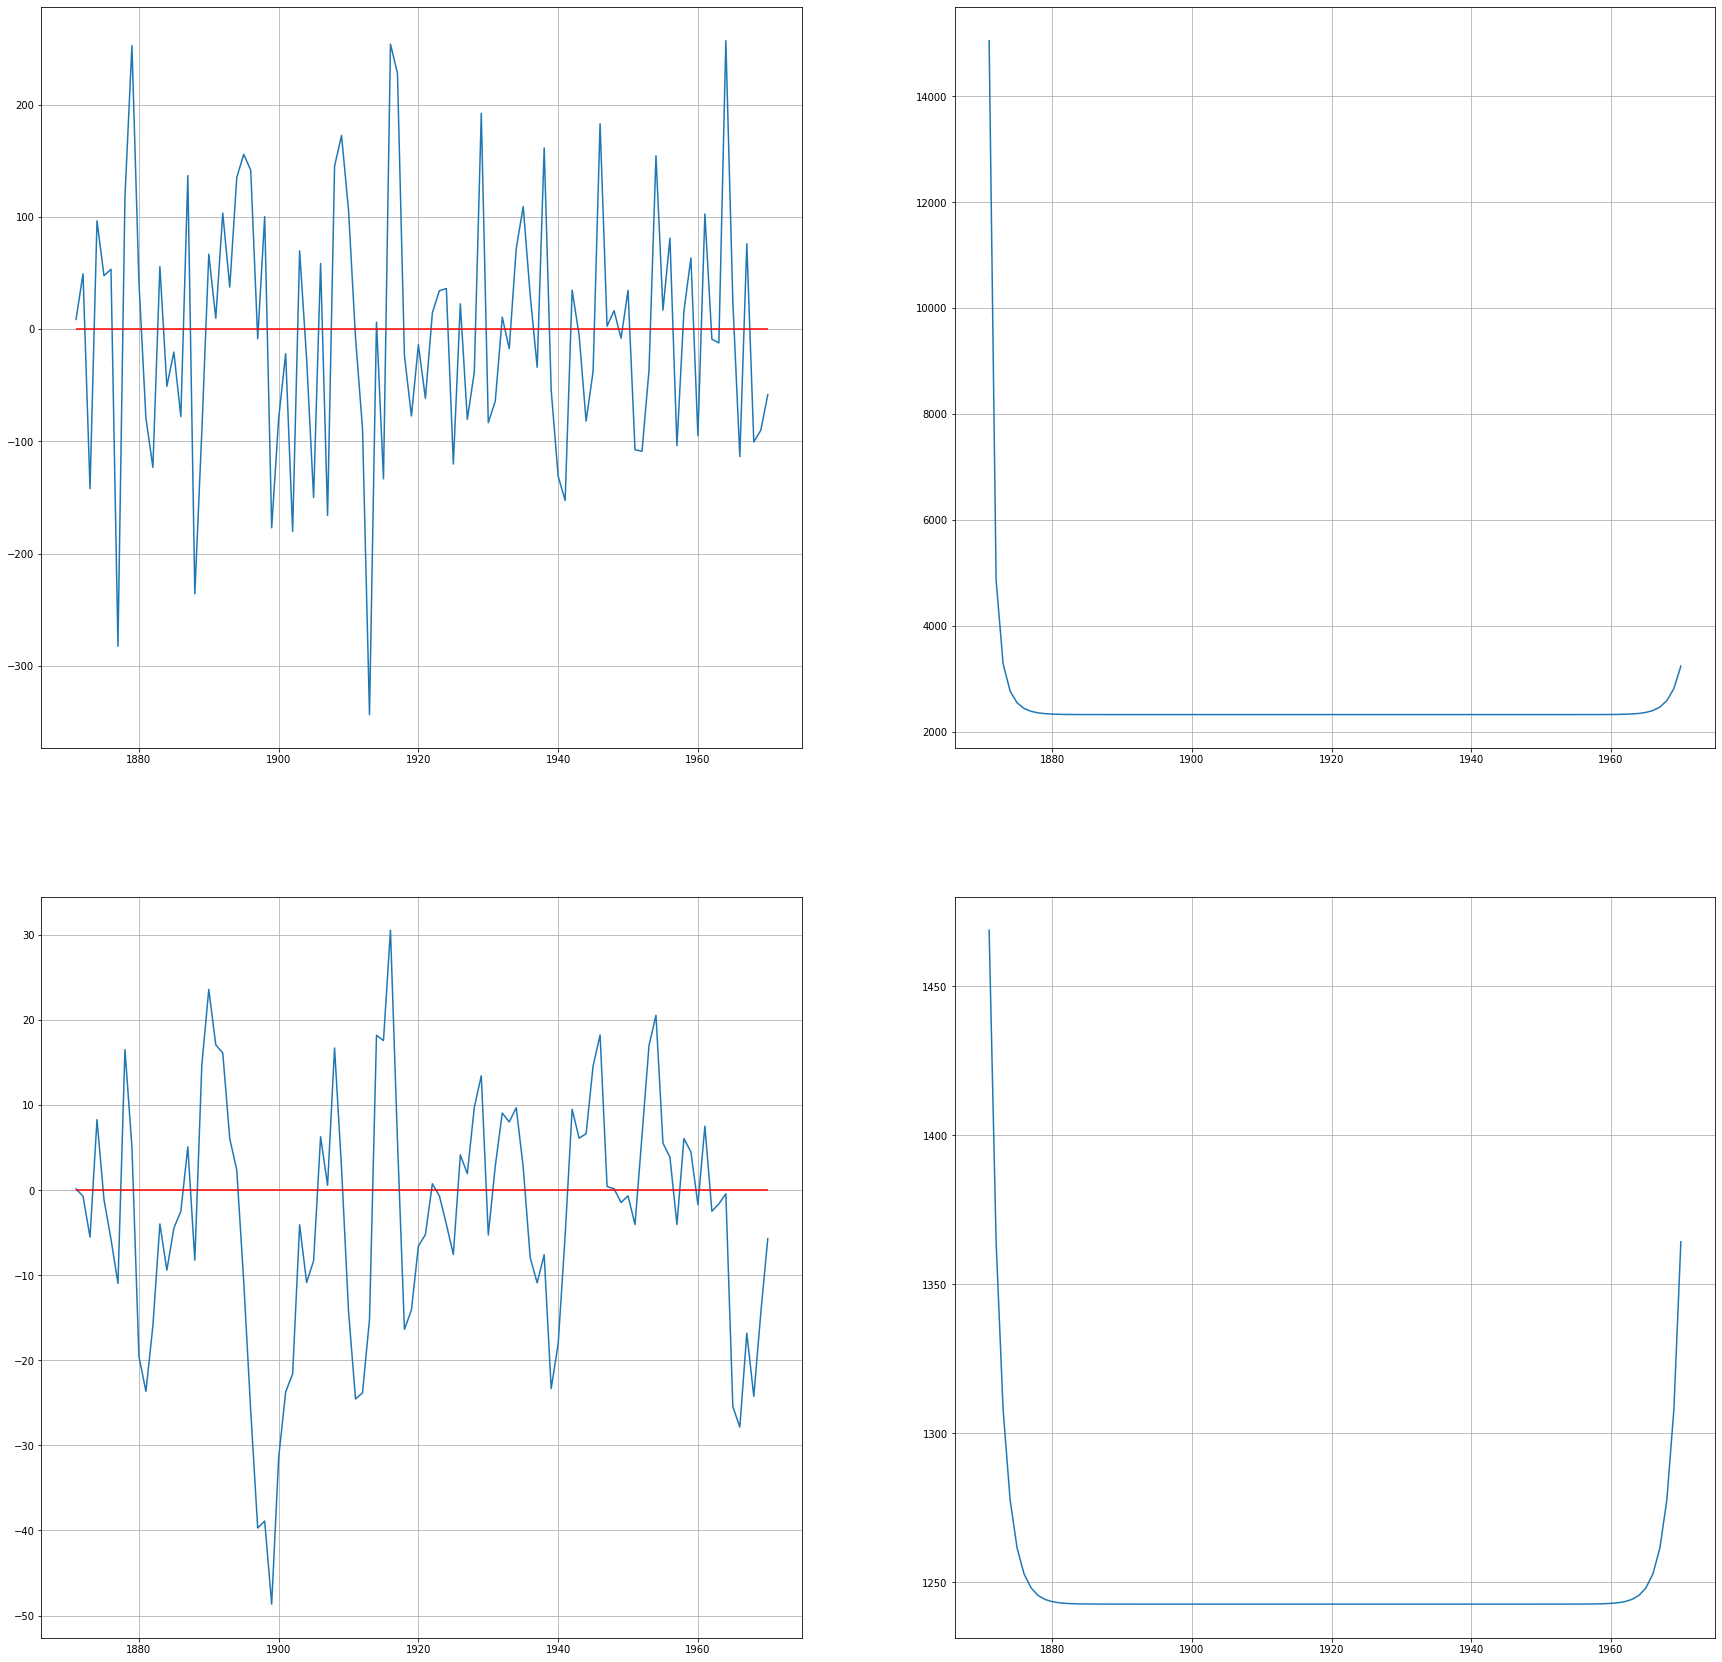

In [244]:
def dist_smoothing(y: pd.Series, P1, a1, s2_e, s2_n, r_int, N_int):
    ind = y.index
    series = y.copy().to_list()
    df_kf = Kalman_filter(y, P1,a1, s2_e, s2_n)
    df_ks = Kalman_smoother(y, P1, a1, s2_e, s2_n, r_int, N_int)
    df_ds = pd.DataFrame(columns=['eps', 'n', 'var_eps', 'var_n'])

    for i, row in df_ks.iterrows():

        eps = row.y - row.a

        D = row.F**(-1) + row.K**2 * row.N
        var_eps = s2_e - s2_e**2 * D
        var_n = s2_n - s2_n**2 * row.N
        n = s2_n * row.r
        
        df_ds.loc[i] = [eps, n, var_eps, var_n]

    df_ds.index = df_ks.index
    df_ds["y"] = df_ks["y"]

    return df_ds

df_ds = dist_smoothing(y=df.Nile, P1=1e7, a1=0, s2_e=15099, s2_n=1469.1, r_int=0, N_int=0)
print(df_ds)
fig, axs = plt.subplots(2,2, figsize=(30,30))

# upper left
ax = axs[0,0]
ax.plot(df_ds.index, df_ds['eps'])
ax.hlines(y = 0, xmin= df.index.min(), xmax=df.index.max(), color = 'r', linestyle = '-')

# lower left
ax = axs[1,0]
ax.plot(df_ds.index, df_ds['n'])
ax.hlines(y = 0, xmin= df.index.min(), xmax=df.index.max(), color = 'r', linestyle = '-')

# upper right
ax = axs[0,1]
ax.plot(df_ds.index, df_ds['var_eps'])


# lower right
ax = axs[1,1]
ax.plot(df_ds.index, df_ds['var_n'])

# make nice plot
for row in axs:
    for ax in row:
        ax.grid()
        pass


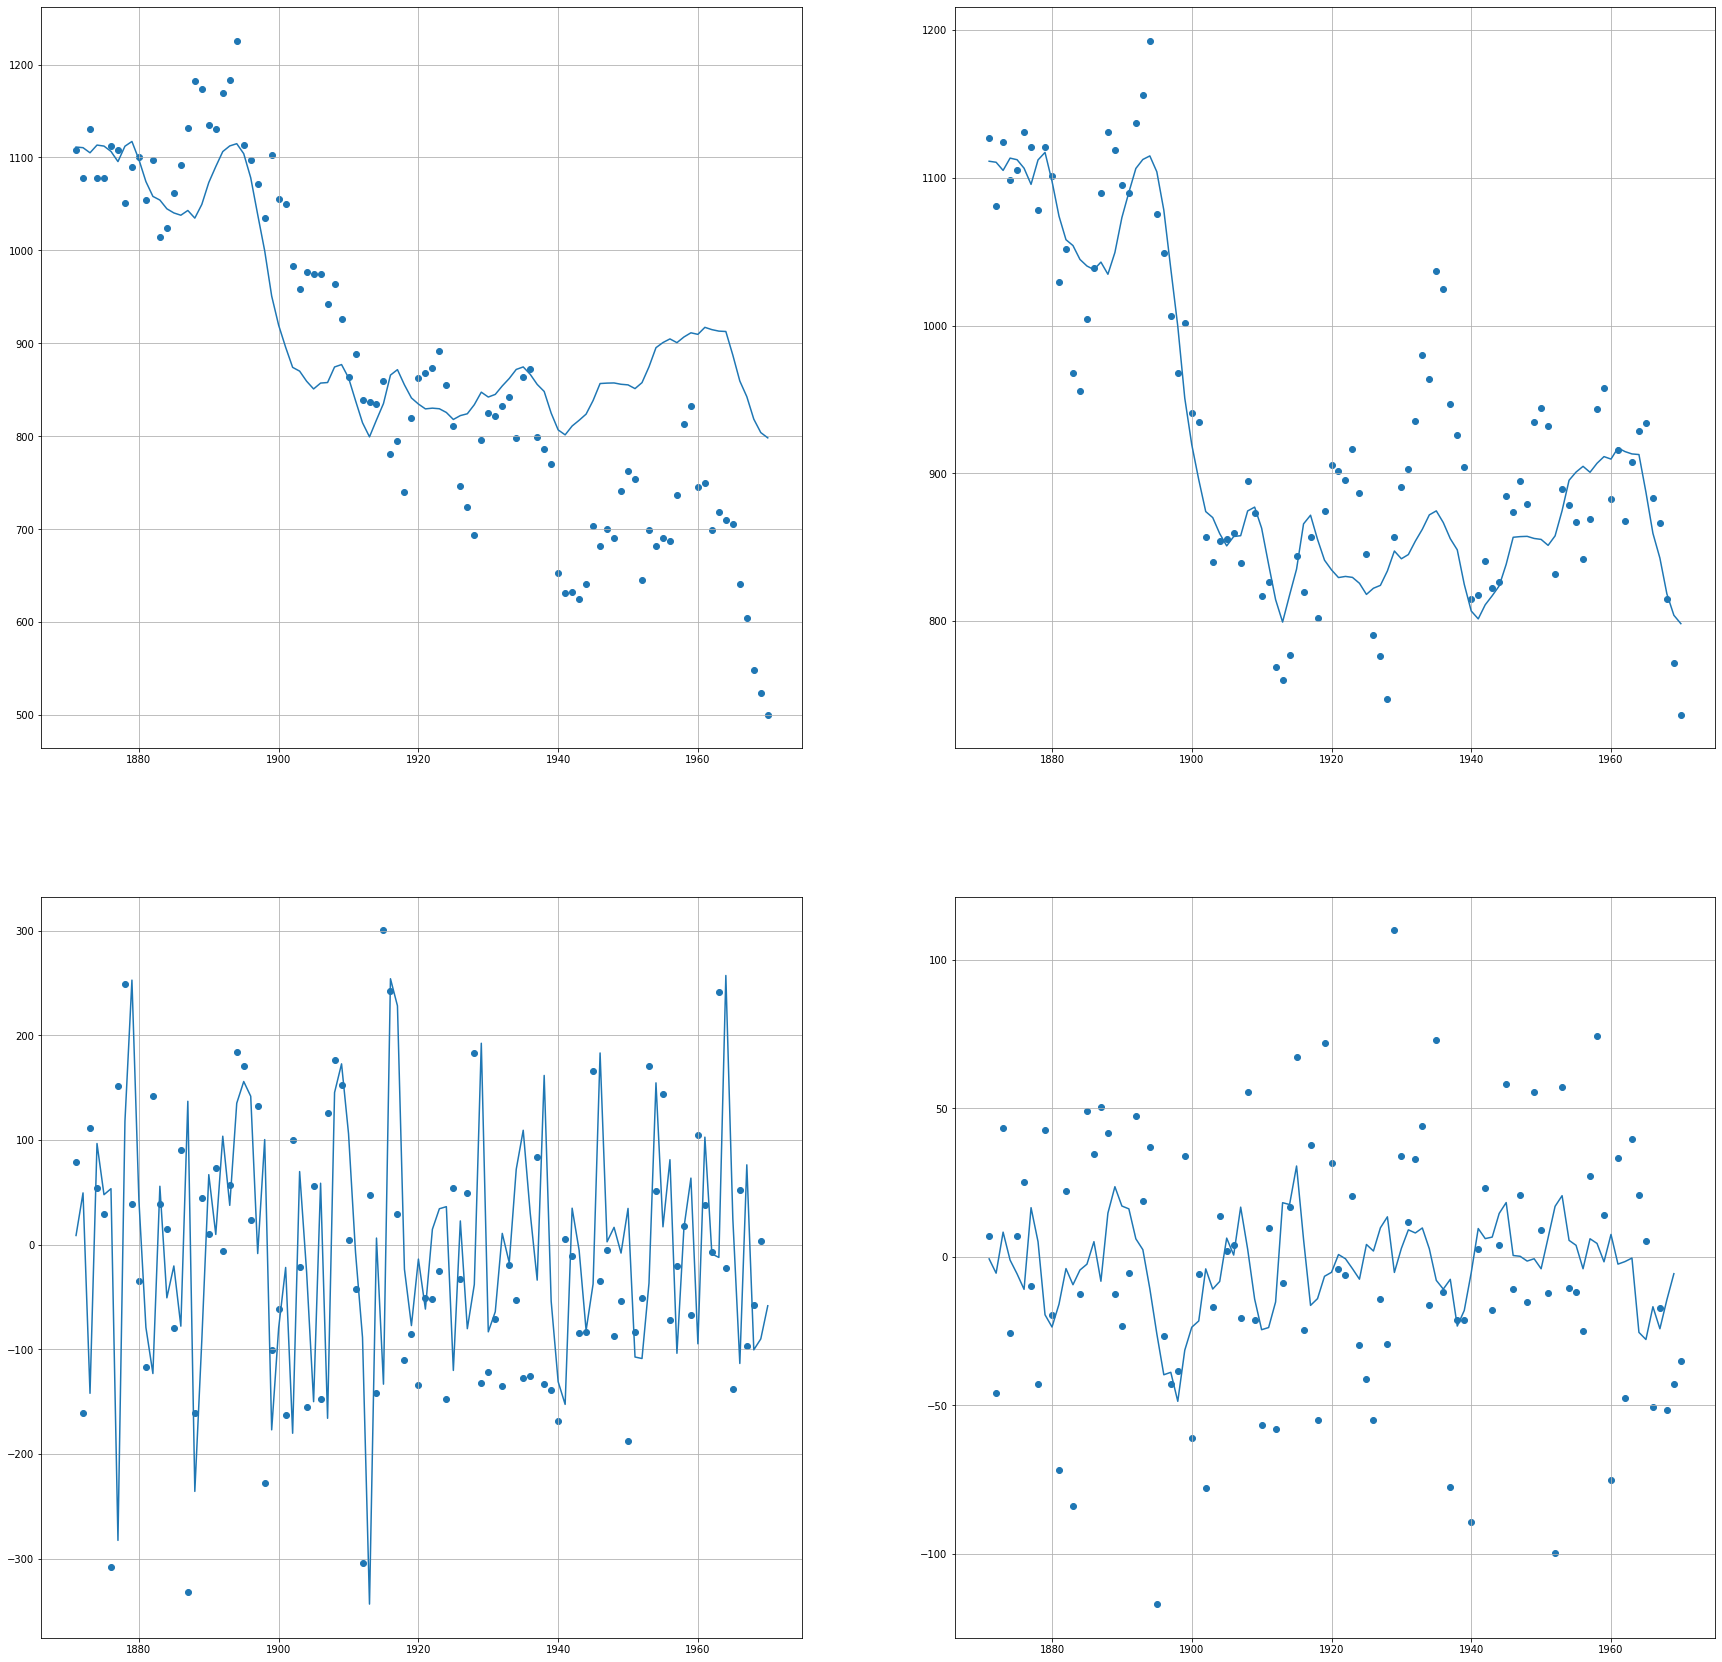

In [245]:
def llm_sim(df, P1, a1, s2_e, s2_n, r_int, N_int, a1_plus):

    df_kf = Kalman_filter(df.Nile, P1, a1, s2_e, s2_n)
    df_ks = Kalman_smoother(df.Nile, P1, a1, s2_e, s2_n, r_int, N_int)
    df_ks["eps"] = df_ks.y - df_ks.a
    df_ds = dist_smoothing(df.Nile, P1, a1, s2_e, s2_n, r_int, N_int)
    
    # draw sample
    eps_list = np.random.randn(len(df)) * np.sqrt(s2_e)
    eta_list = np.random.randn(len(df)) * np.sqrt(s2_n)
    df_sim = pd.DataFrame({
        "eps_sim": eps_list,
        "eta_sim": eta_list,
        "y_sim": a1_plus + np.cumsum(eta_list) + eps_list,
        "a_sim": a1_plus + np.cumsum(eta_list)
    })
    
    df_sim_ks = Kalman_smoother(df_sim.y_sim, P1, a1, s2_e, s2_n, r_int, N_int)

    a = a1_plus
    a_prev = a1_plus
    df_llm = pd.DataFrame(columns=['alpha_kringeltje', 'eps_kringeltje', 'eta_kringeltje'])
    for i, y in enumerate(df.Nile.to_list()):

        # draw random variables
        row_ks = df_sim_ks.loc[i]
        eps_sim_est = row_ks.y - row_ks.a
        eps_sim = eps_list[i]

        # eps_kringeltje = eps - 
        eps_kringeltje = eps_sim - eps_sim_est + df_ks.iloc[i]["eps"]
        a_kringeltje = y - eps_kringeltje
        
        eta_kringeltje = a_kringeltje - a_prev
        a_prev = a_kringeltje
        
        # store result
        df_llm.loc[i] = [a_kringeltje, eps_kringeltje, eta_kringeltje]
        
    # add true data to df
    df_llm["y"] = df.Nile.to_list()
    df_llm["eps_kringeltje"] = df_llm["eps_kringeltje"].shift(-1)
    df_llm.index = df.index
    
    # store simulation in df_llm
    df_llm["y_sim"] = df_sim["y_sim"].to_list()
    df_llm["a_sim"] = df_sim["a_sim"].to_list()
    return df_ks, df_llm

df_ks, df_llm = llm_sim(df=df, P1=1e7, a1=0, s2_e=15099, s2_n=1469.1, r_int=0, N_int=0, a1_plus=df.Nile.values[0])

fig, axs = plt.subplots(2,2, figsize=(30,30))

# upper left
ax = axs[0,0]
ax.scatter(df_llm.index, df_llm.a_sim)
ax.plot(df_ks.index, df_ks.a)

# lower left
ax = axs[1,0]
ax.plot(df_ks.index, (df_ks.y - df_ks.a))
ax.scatter(df_llm.index, df_llm.eps_kringeltje)

# upper right
ax = axs[0,1]
ax.plot(df_ks.index, df_ks.a)
ax.scatter(df_llm.index, df_llm.alpha_kringeltje)


# lower right
ax = axs[1,1]
ax.plot(df_ks.index, df_ks.a.diff().shift(-1))
ax.scatter(df_llm.index, df_llm.eta_kringeltje)

# make nice plot
for row in axs:
    for ax in row:
        ax.grid()
        pass      
plt.show()  

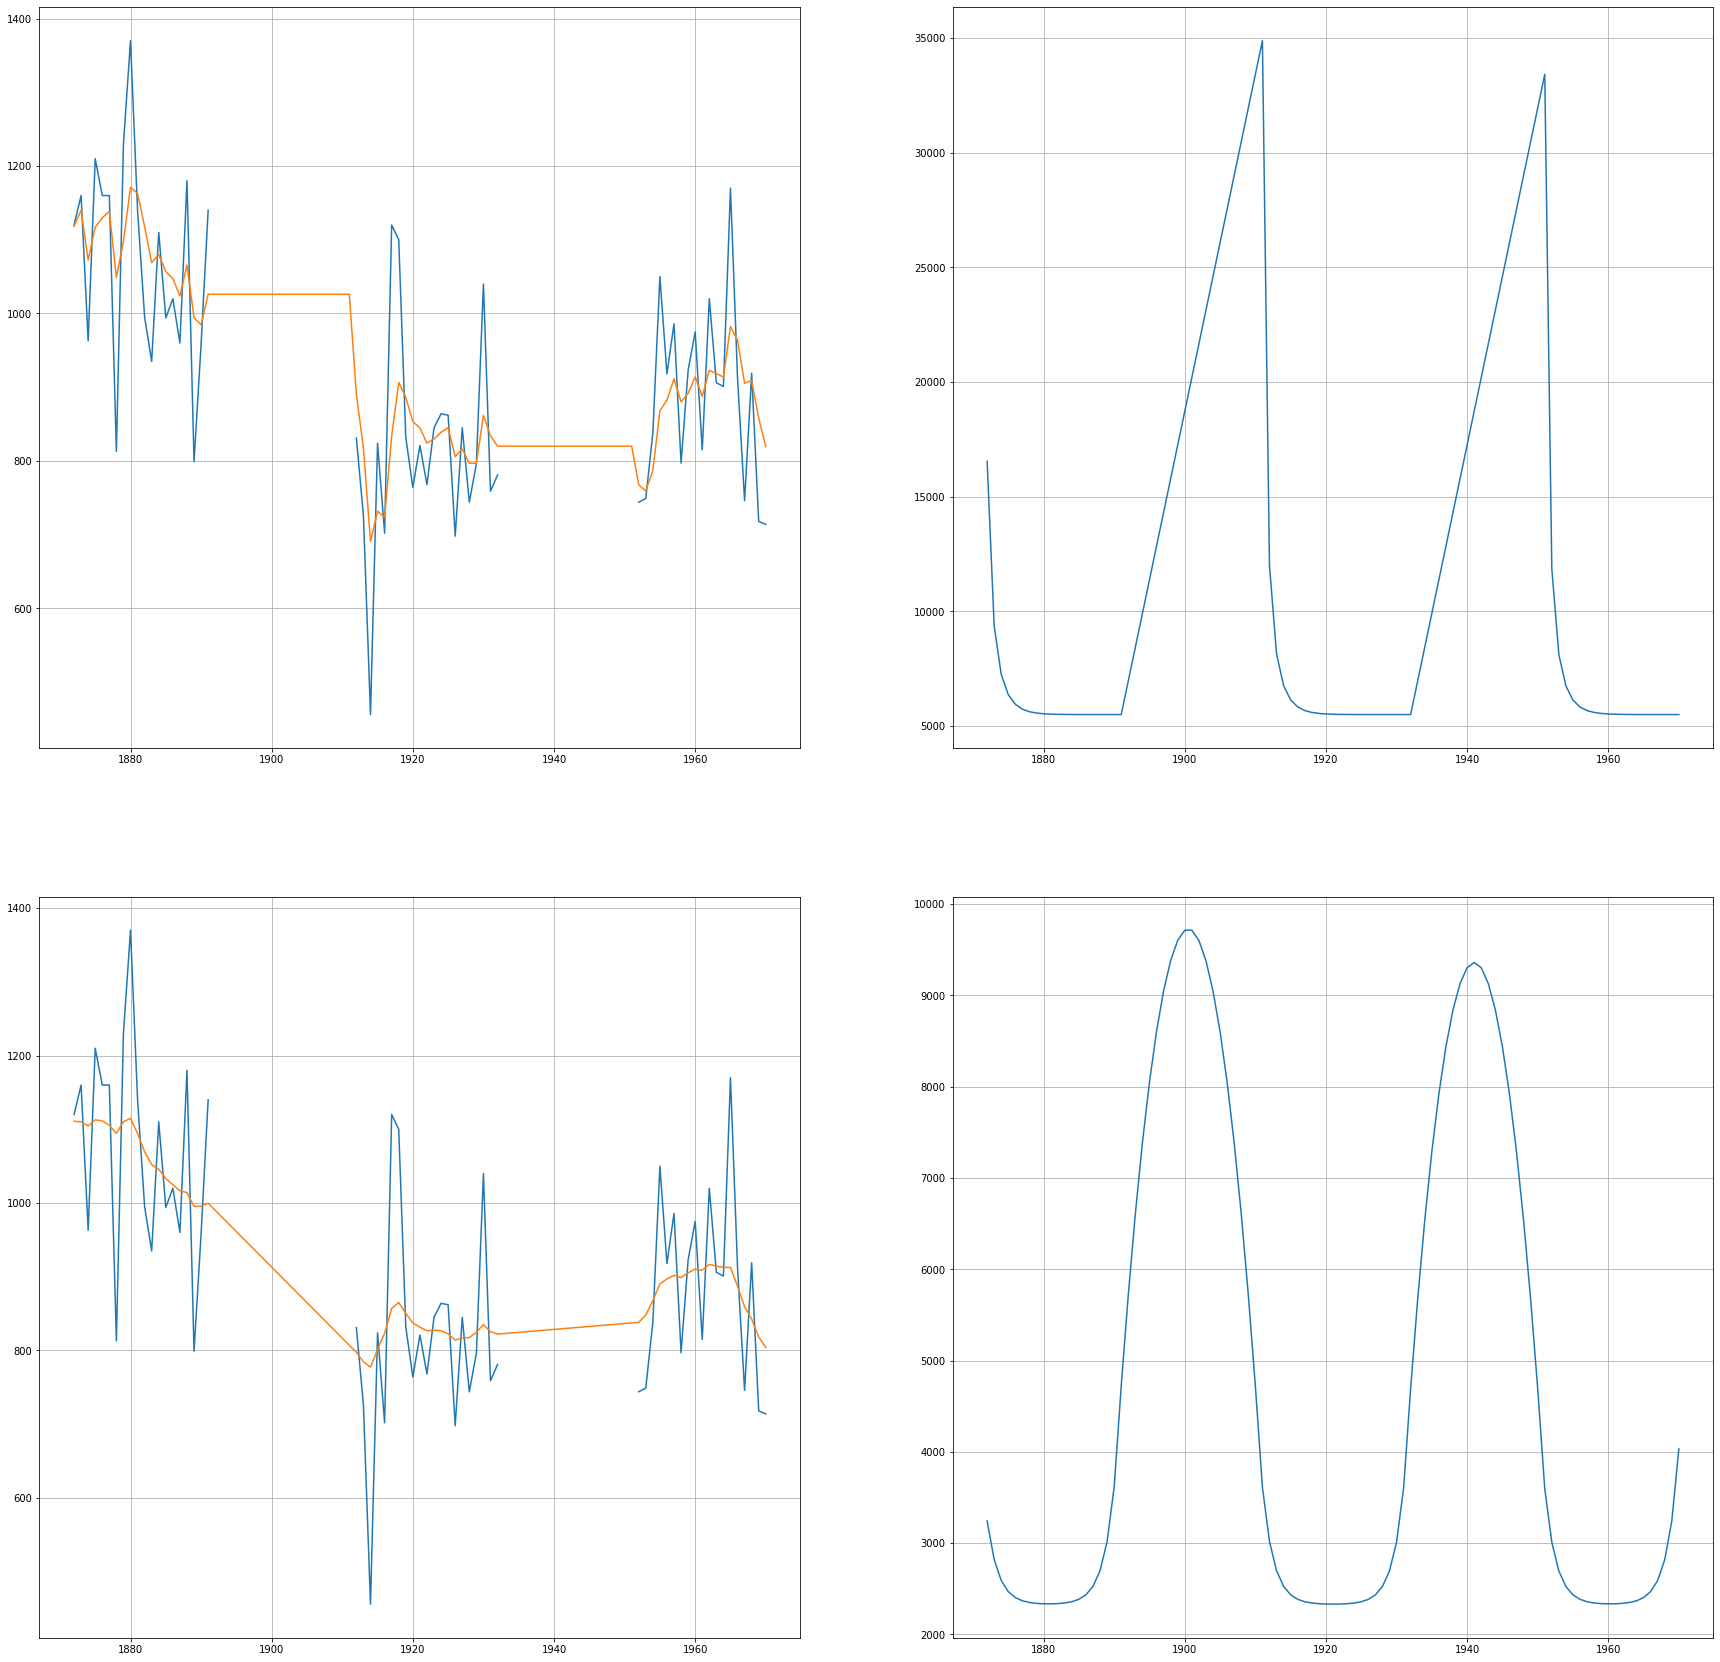

In [266]:
def missing_vals(df, P1, a1, s2_e, s2_n, r_n, N_n):

    df_mis = df.copy()
    ind = df_mis.index
    df_mis[(df_mis.index<df_mis.index[0]+40) & (df_mis.index>=df_mis.index[0]+20)] = np.nan
    df_mis[(df_mis.index<df_mis.index[0]+80) & (df_mis.index>=df_mis.index[0]+61)] = np.nan

    df_kf = Kalman_filter(series=df_mis.Nile, P1=P1, a1=a1, s2_e=s2_e, s2_n=s2_n)
    df_ks = Kalman_smoother(y=df_mis.Nile, P1=P1, a1=a1, s2_e=s2_e, s2_n=s2_n, r_n=r_n, N_n=N_n)

    df_mv = pd.DataFrame(columns=['Nile', 'a_f', 'P_f', 'alpha_s', 'V_s'])
    df_mv['Nile'] = df_mis.Nile
    df_mv['a_f'] = df_kf['a']
    df_mv['P_f'] = df_kf['P']
    df_mv['alpha_s'] = df_ks['a']
    df_mv['V_s'] = df_ks['V']

    df_mv.index = ind
    df_mv.loc[df_mv.index[0]] = [df_mv['Nile'][df_mv.index[0]], np.nan, np.nan, df_ks.a[df_mv.index[0]], np.nan]

    return df_mv

df_mv = missing_vals(df=df, P1=1e7, a1=0, s2_e=15099, s2_n=1469.1, r_n=0, N_n=0)

fig, axs = plt.subplots(2,2, figsize=(30,30))

# upper left
ax = axs[0,0]
ax.plot(df_mv.index, df_mv.Nile.shift(1))
ax.plot(df_mv.index, df_mv.a_f)

# lower left
ax = axs[1,0]
ax.plot(df_mv.index, df_mv.Nile.shift(1))
ax.plot(df_mv.index, df_mv.alpha_s.shift(1))

# upper right
ax = axs[0,1]
ax.plot(df_mv.index, df_mv.P_f)

# lower right
ax = axs[1,1]
ax.plot(df_mv.index, df_mv.V_s)

# make nice plot
for row in axs:
    for ax in row:
        ax.grid()
        pass      
plt.show()

Index(['a', 'P', 'v', 'F', 'K', 'ci', 'y'], dtype='object')


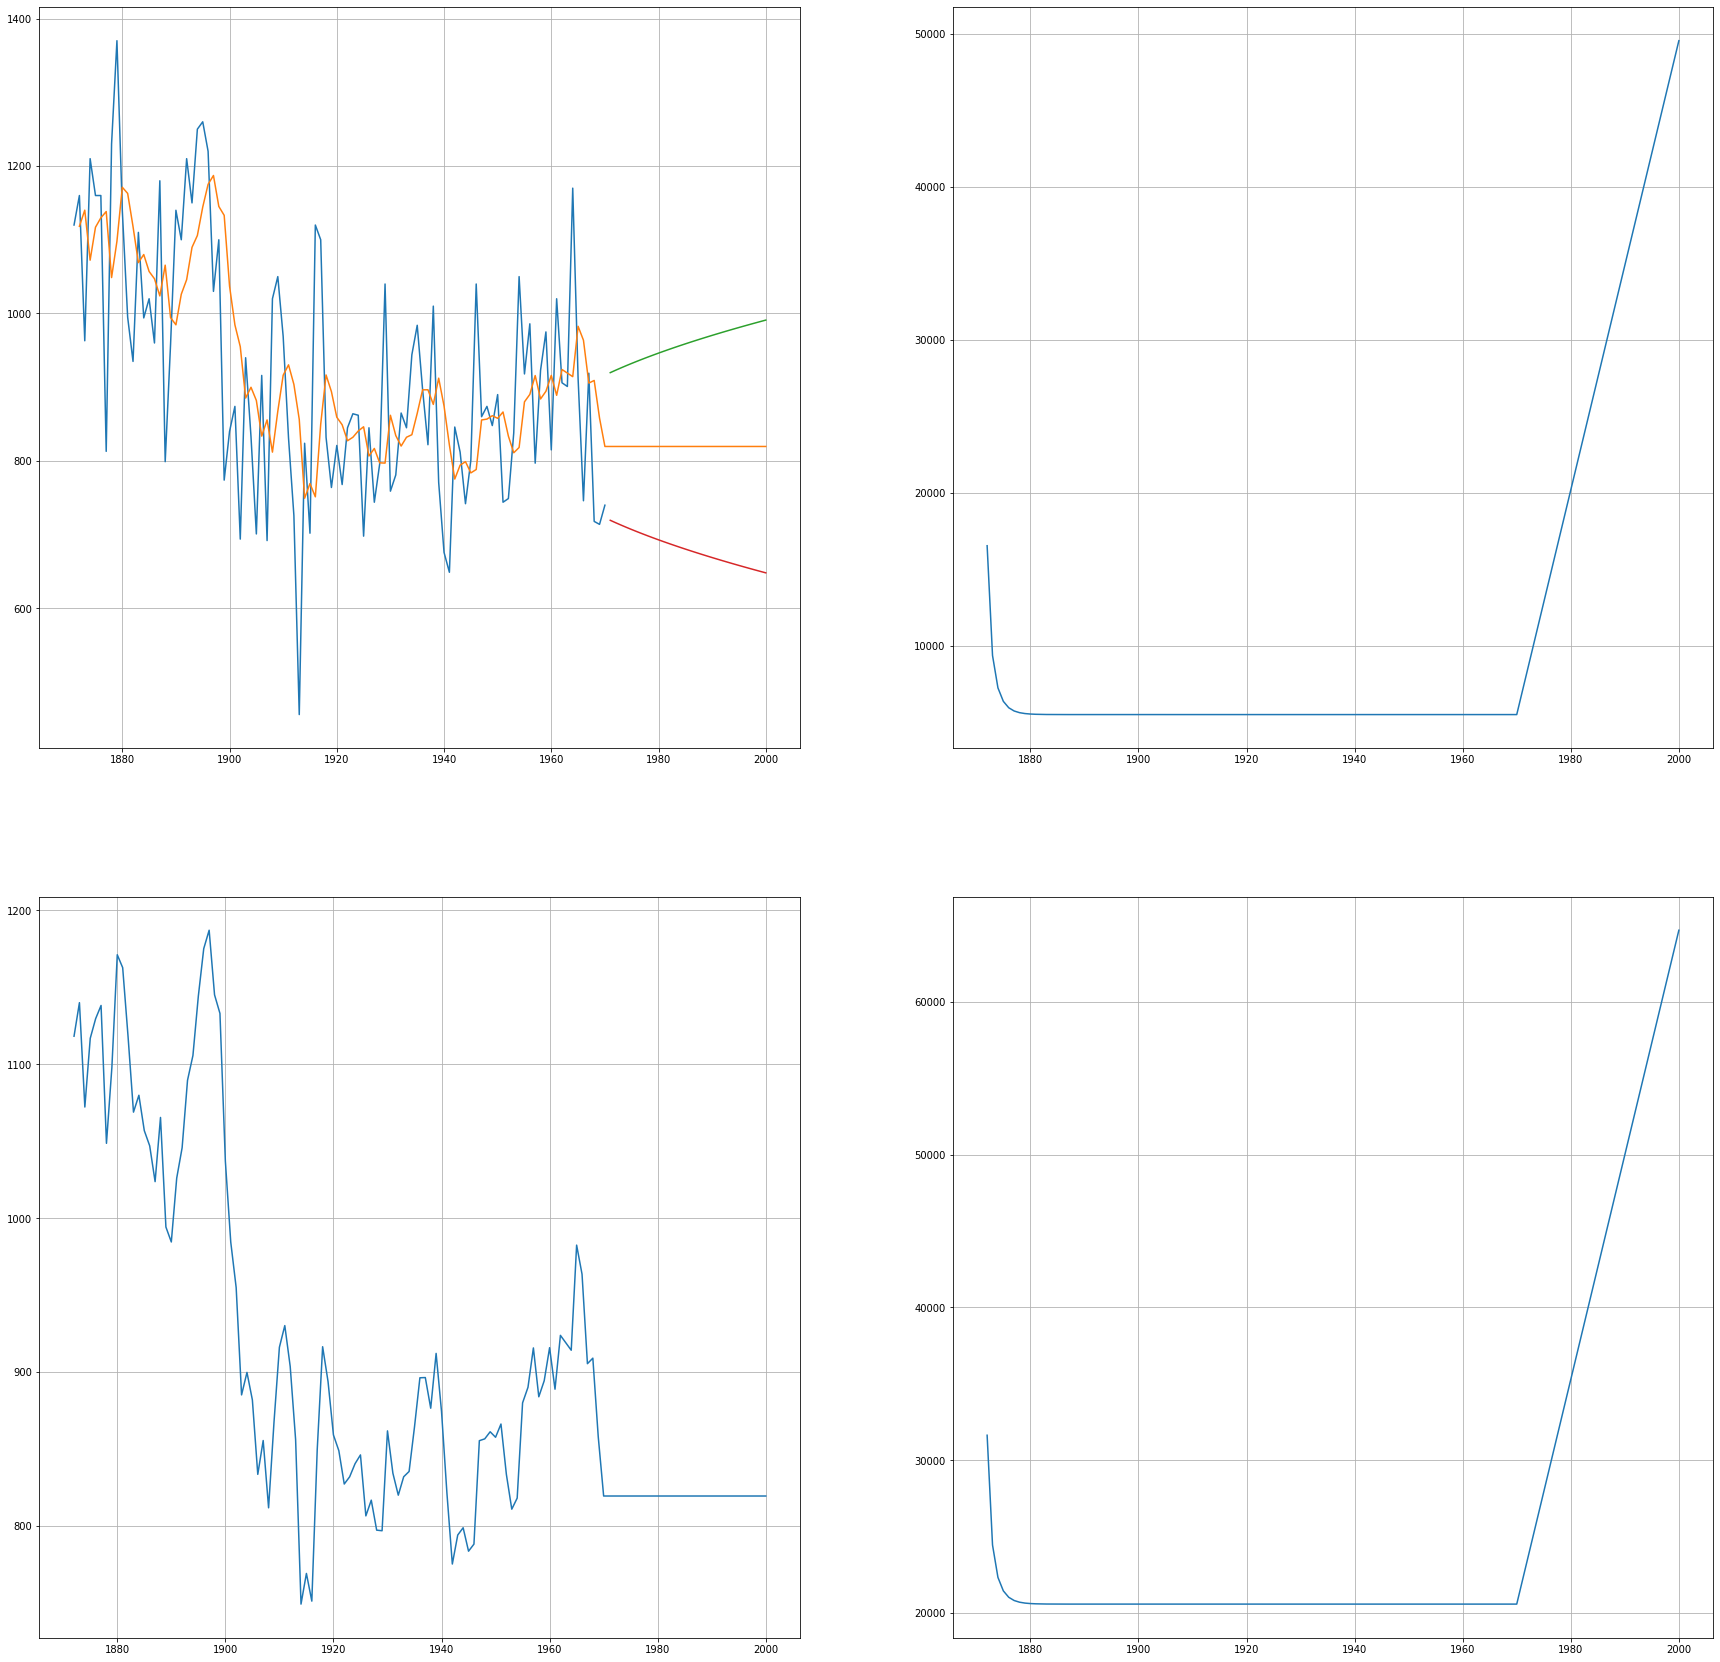

In [275]:
def Kalman_filter_forecast(series: pd.Series, P1, a1, s2_e, s2_n, T_pred):
    
    df_kf = Kalman_filter(df.Nile, P1, a1, s2_e, s2_n)
    row = df_kf.iloc[-1]
    print(df_kf.columns)

    a = row.a
    P = row.P
    
    t_start = df_kf.index.max() + 1
    t_end = t_start + T_pred
    
    for i in range(t_start, t_end):
        P += s2_n
        F = P + s2_e
        df_kf.loc[i] = [a, P, np.nan, F, np.nan, np.nan, np.nan]
    return df_kf.iloc[1:]
    
df_kf =  Kalman_filter_forecast(df.Nile, 1e7, 0, 15099, 1469.1, T_pred=30)

fig, axs = plt.subplots(2,2, figsize=(30,30))

# upper left
ax = axs[0,0]
ax.plot(df.index, df.Nile)
ax.plot(df_kf.index, df_kf.a)
df_pred = df_kf.copy().iloc[-30:]
t_crit = .674 # 50 percent, two sided z-value
ax.plot(df_pred.index, df_pred.a + t_crit * np.sqrt(df_pred.F))
ax.plot(df_pred.index, df_pred.a - t_crit * np.sqrt(df_pred.F))

# lower left
ax = axs[1,0]
ax.plot(df_kf.index, df_kf.a)

# upper right
ax = axs[0,1]
ax.plot(df_kf.index, df_kf.P)

# lower right
ax = axs[1,1]
ax.plot(df_kf.index, df_kf.F)

# make nice plot
for row in axs:
    for ax in row:
        ax.grid()
        pass      
plt.show()


<AxesSubplot:>

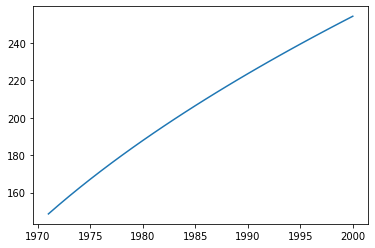